In [9]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import warnings

def get_base_data(fp):

    # Load the data
    df = pd.read_excel(fp)

    # addadditional features
    
    def count_previous_attempts(row, minutes_window=5):
        same_amount = df['amount'] == row['amount']
        same_country = df['country'] == row['country']
        time_window = (df['tmsp'] >= (row['tmsp'] - timedelta(minutes=minutes_window))) & (df['tmsp'] < row['tmsp'])
        return df[same_amount & same_country & time_window].shape[0]
    df["hour_of_day"] = df["tmsp"].dt.hour
    df["day_of_week"] = df["tmsp"].dt.dayofweek
    df['previous_attempts'] = df.apply(count_previous_attempts, axis=1)

    df.to_pickle("df2.pkl")

    return df

def get_base_data_from_pickle(fp):
    return pd.read_pickle(fp)

In [2]:
#df = get_base_data(r"G:\My Drive\masterDataScience\ModelEngineering\use_case_1\PSP_Jan_Feb_2019.xlsx")
df = get_base_data_from_pickle(r"df.pkl")


country
['Germany' 'Austria' 'Switzerland']
success
['0' '1']
PSP
['UK_Card' 'Simplecard' 'Moneycard' 'Goldcard']
3D_secured
['0' '1']
card
['Visa' 'Diners' 'Master']


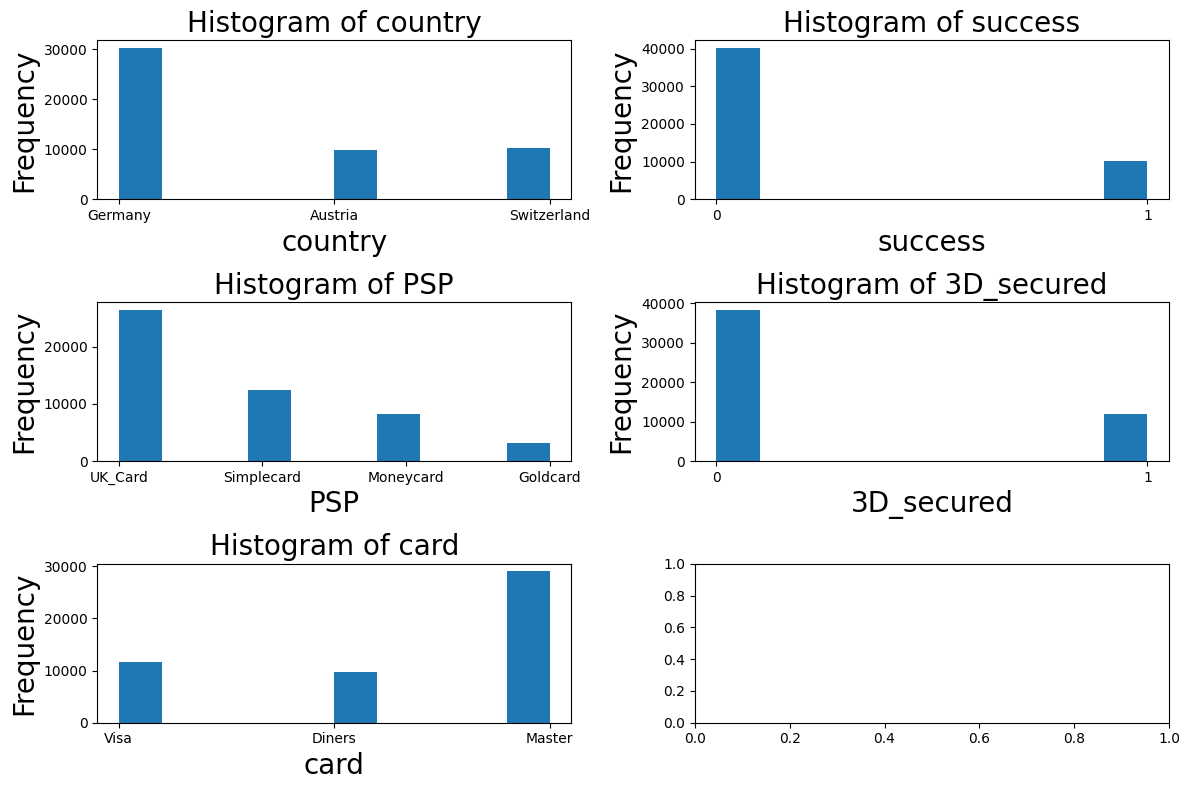

In [3]:
nrows, ncols = 3, 2
font_size = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))

axes = axes.flatten()
axes = axes[:5]

df_str = df.astype(str)

for i, column in enumerate(df_str[["country", "success", "PSP", "3D_secured", "card"]].columns):
    if 1 == 1:
        ax = axes[i]
        ax.hist(df_str[column])
        ax.set_title(f'Histogram of {column}', fontsize=font_size)
        ax.set_xlabel(column, fontsize=font_size)
        ax.set_ylabel('Frequency', fontsize=font_size)
        ax.tick_params(axis='both', labelsize=10)

    print(column)
    print(df_str[column].unique())

for i in range(len(df_str.columns), (nrows * ncols)-1):
    fig.delaxes(axes[i])

fig.tight_layout()

plt.show()


amount
6
630
96.2737752409059
numeric_tmsp
2019-01-01 00:01:11
2019-02-28 23:48:19


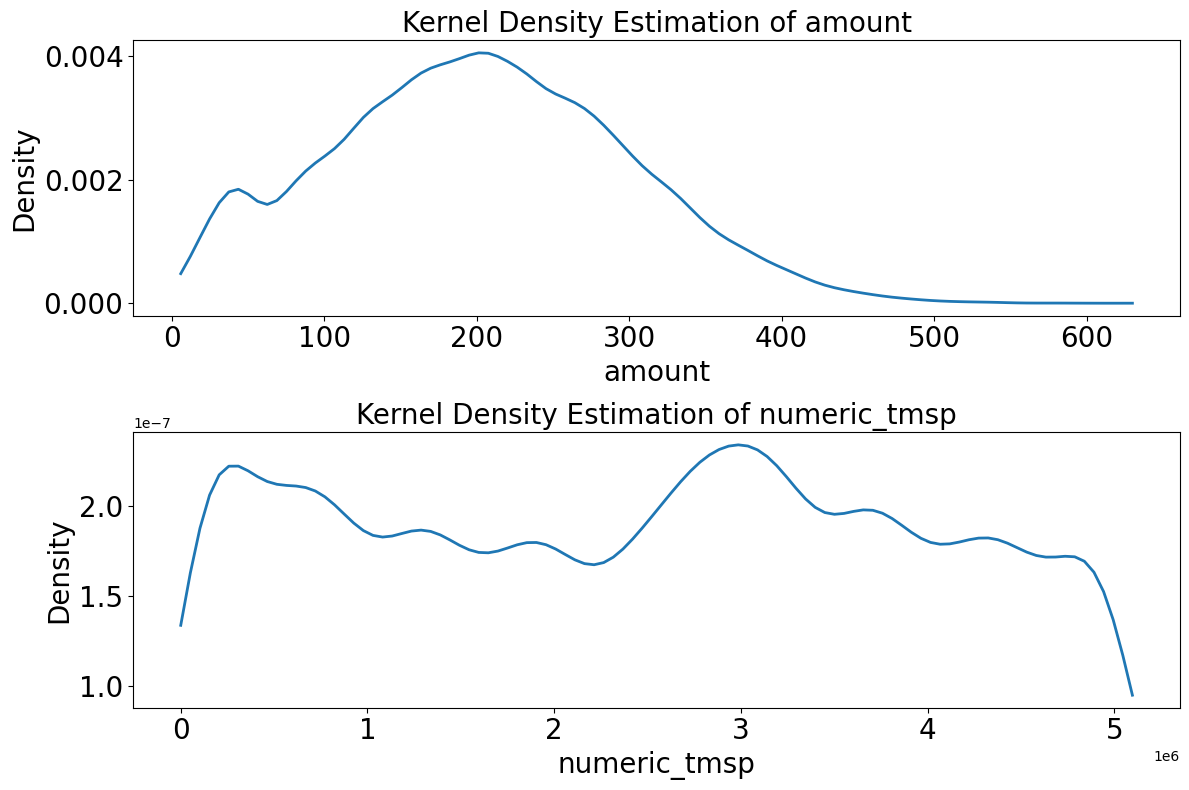

In [4]:
nrows, ncols = 2, 1
font_size = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))

axes = axes.flatten()

df['numeric_tmsp'] = (df['tmsp'] - df['tmsp'].min()).dt.total_seconds()
for i, column in enumerate(df[["amount", "numeric_tmsp"]].columns):
    if 1 == 1:
        ax = axes[i]
        kde = gaussian_kde(df[column])
        x = np.linspace(min(df[column]), max(df[column]), 100)
        y = kde(x)
        ax.plot(x, y, linewidth=2)  # Plot the KDE
        ax.set_title(f'Kernel Density Estimation of {column}', fontsize=font_size)  # Set title font size
        ax.set_xlabel(column, fontsize=font_size)  # Set x-axis label font size
        ax.set_ylabel('Density', fontsize=font_size)  # Set y-axis label font size
        ax.tick_params(axis='both', labelsize=font_size)
    print(column)
    if column == "amount":
        print(min(df[column]))
        print(max(df[column]))
        print(np.std(df[column]))
    else:
        print(min(df["tmsp"]))
        print(max(df["tmsp"]))

for i in range(len(df_str.columns), nrows * ncols):
    fig.delaxes(axes[i])

fig.tight_layout()

plt.show()


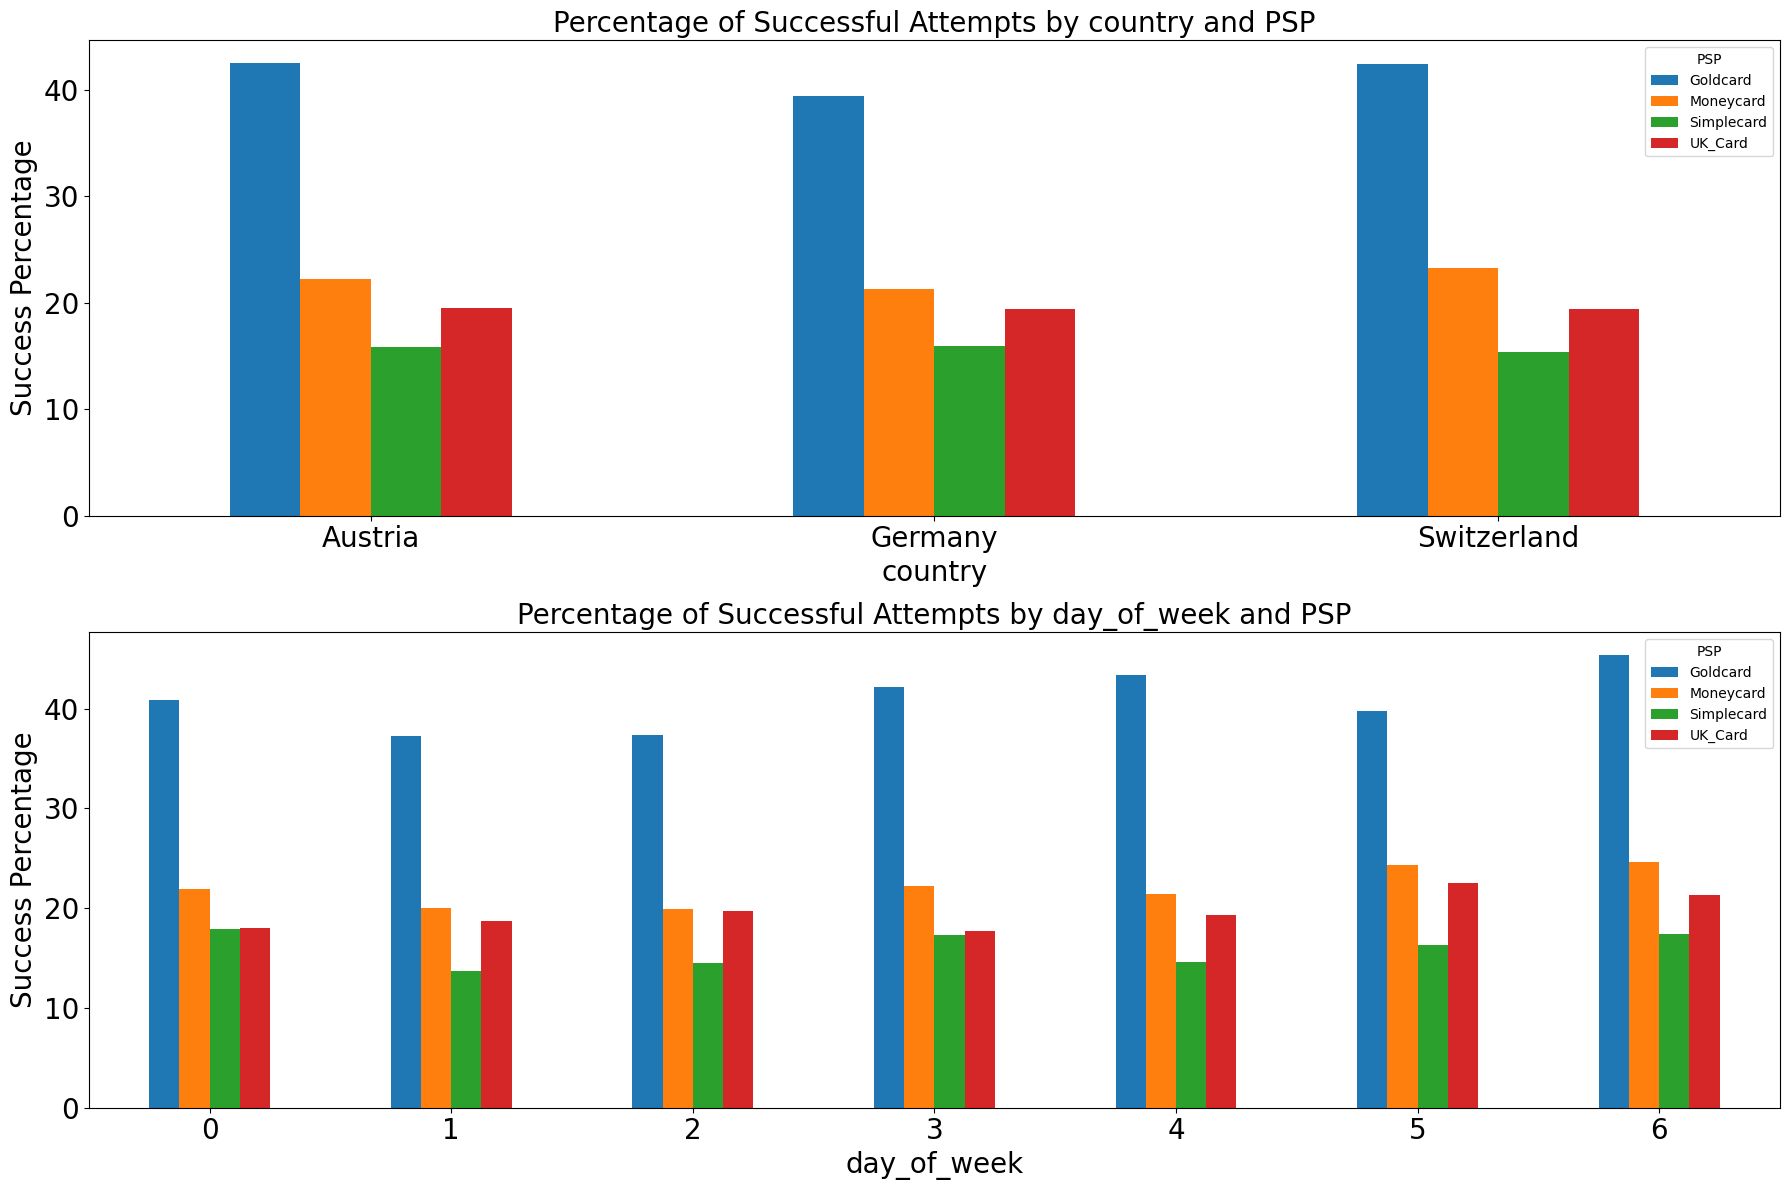

In [5]:
def plot_hist_per_psp(df, col, ax, font_size = 20):
    grouped = df.groupby([col, 'PSP'])['success'].mean() * 100
    pivot_table = grouped.unstack(level=1)

    pivot_table.plot(kind='bar', stacked=False, ax=ax)
    ax.set_title(f'Percentage of Successful Attempts by {col} and PSP', fontsize=font_size)
    ax.set_xlabel(col, fontsize=font_size)
    ax.set_ylabel('Success Percentage', fontsize=font_size)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=font_size)
    ax.legend(title='PSP', loc='upper right')
    ax.tick_params(axis='both', labelsize=20)

# Create a single figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 12))
columns = ["country", "day_of_week"]

# Flatten the axes array to access each subplot
axes = axes.flatten()

for i, col in enumerate(columns):
    plot_hist_per_psp(df, col, axes[i])

plt.tight_layout()
plt.show()


C:\Users\oliver.koehn\AppData\Local\Temp\ipykernel_23828\906956400.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticks(), fontsize=font_size, color='blue')  # Set the color for right y-axis labels


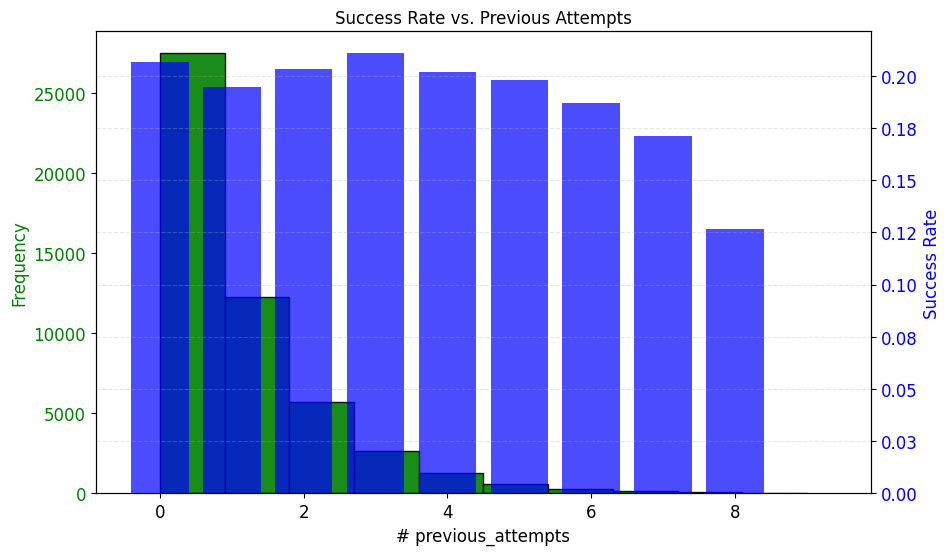

In [6]:
# Specify the font size
font_size = 12

# Create the histogram
plt.figure(figsize=(10, 6))
ax1 = plt.gca()  # Get the current axes (left y-axis)
plt.hist(df['previous_attempts'], edgecolor='black', alpha=0.9, color='green')  # Set the color for left bars
plt.xlabel('# previous_attempts', fontsize=font_size)
plt.ylabel('Frequency', fontsize=font_size, color='green')

# Set font size and color for tick labels on the left y-axis
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, color='green')  # Set the color for left y-axis labels

# Group the data by 'previous_attempts' and calculate the mean success rate
success_rate = df.groupby('previous_attempts')['success'].mean()

# Create a histogram plot
ax2 = ax1.twinx()  # Create a twin axes (right y-axis)
ax2.bar(success_rate.index, success_rate.values, align='center', alpha=0.7, color='blue')  # Set the color for right bars
ax2.set_ylabel('Success Rate', fontsize=font_size, color='blue')  # Set the color for right y-axis labels

# Customize the right y-axis plot
ax2.set_yticklabels(ax2.get_yticks(), fontsize=font_size, color='blue')  # Set the color for right y-axis labels

ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))

# Show the combined plot
plt.title('Success Rate vs. Previous Attempts')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


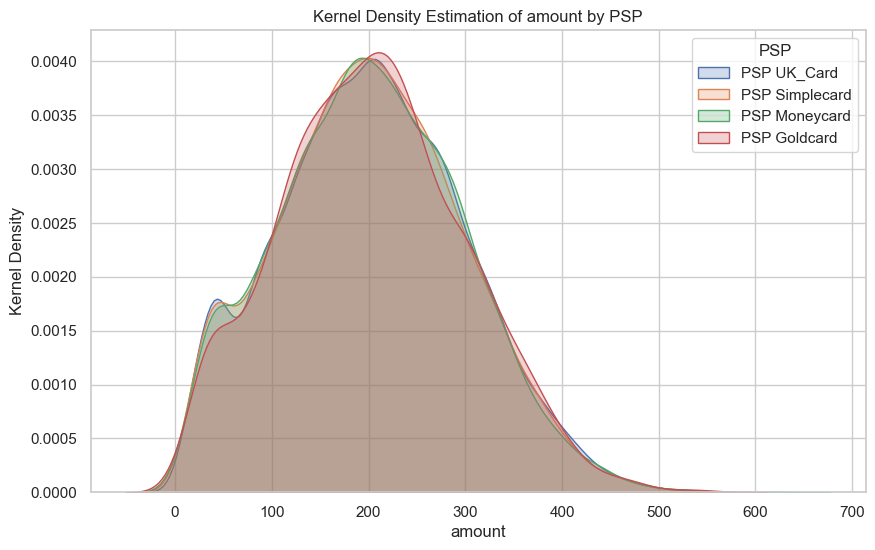

In [11]:
warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_kde_all(df, col):
    sns.set(style="whitegrid")
    df_filtered = df[[col, 'PSP', 'success']]
    plt.figure(figsize=(10, 6))
    for psp_value in df_filtered['PSP'].unique():
        data_subset = df_filtered[df_filtered['PSP'] == psp_value]
        sns.kdeplot(data_subset[col], label=f'PSP {psp_value}', shade=True)
    plt.xlabel(col)
    plt.ylabel("Kernel Density")
    plt.title(f'Kernel Density Estimation of {col} by PSP')
    plt.legend(title='PSP', loc='upper right')
    plt.show()

plot_kde_all(df, 'amount')


In [13]:
num_cols = ["amount", "previous_attempts"]
cat_cols = ["country", "PSP", "3D_secured", "card", "day_of_week"]
target_col = "success"

list_features = num_cols + cat_cols

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

# https://scikit-learn.org/1.0/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions

col_trans = ColumnTransformer([
    ('num', MinMaxScaler(), num_cols),
    ('cat', OneHotEncoder(drop='if_binary'), cat_cols)
])

df_transformed = col_trans.fit_transform(df[list_features])
X = df_transformed[:, :]
y = df["success"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

# oversampling is important, check difference!!
# Apply oversampling to the training set
oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)


# See the inital model performance
clf = RandomForestClassifier(random_state=10)
print("Random parameters")
print('Acc:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean())
print('F1:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1').mean())
print('ROC AUC:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc').mean())

params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

Random parameters
Acc: 0.8725602030436802
F1: 0.8841049491431157
ROC AUC: 0.9327074757286496


In [15]:
# train network
clf = RandomForestClassifier(n_estimators=50,
                             max_depth=None,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             random_state=11)
clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=50, random_state=11)

In [16]:
# get the feature importance
feat_names_num = list(col_trans.transformers_[0][1].get_feature_names_out())
feat_names_cat = list(col_trans.transformers_[1][1].get_feature_names_out())
feature_names = feat_names_num + feat_names_cat
df_importance = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
df_importance.sort_values('importance', ascending=False)

,feature,importance
0,amount,0.713942
1,previous_attempts,0.104065
9,3D_secured_1,0.023202
5,PSP_Goldcard,0.017678
3,country_Germany,0.011111
8,PSP_UK_Card,0.010942
7,PSP_Simplecard,0.010209
11,card_Master,0.010024
2,country_Austria,0.010012
4,country_Switzerland,0.009949


In [48]:
import pickle
# save
try:
    df = df.reset_index()
except:
    pass
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('transformer', col_trans),('classifier', clf)])
j_berka = {}
j_berka["network"] = pipeline
j_berka["df"] = df
j_berka["num_cols"] = num_cols
j_berka["cat_cols"] = cat_cols

with open('berka.pickle', 'wb') as f:
    pickle.dump(j_berka, f)


In [49]:
pipeline

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['amount',
                                                   'previous_attempts']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['country', 'PSP',
                                                   '3D_secured', 'card',
                                                   'day_of_week'])])),
                ('classifier', RandomForestClassifier(random_state=10))])

Train Acc (Original): 0.9807302591815693
Train F1 (Original): 0.9810476257080915
Train ROC AUC (Original): 0.9979273540658039
Train Acc (Random Guessing): 0.495911401855868
Train F1 (Random Guessing): 0.4951845192530219
Train ROC AUC (Random Guessing): 0.5
Test Acc (Original): 0.6929841962573563
Test F1 (Original): 0.2603154373108173
Test ROC AUC (Original): 0.5878144202176357
Test Acc (Random Guessing): 0.5063810090590491
Test F1 (Random Guessing): 0.296617356072741
Test ROC AUC (Random Guessing): 0.5
Confusion Matrix (Original) - Train:
Confusion Matrix (Original) - Test:
Confusion Matrix (Random Guessing) - Train:
Confusion Matrix (Random Guessing) - Test:


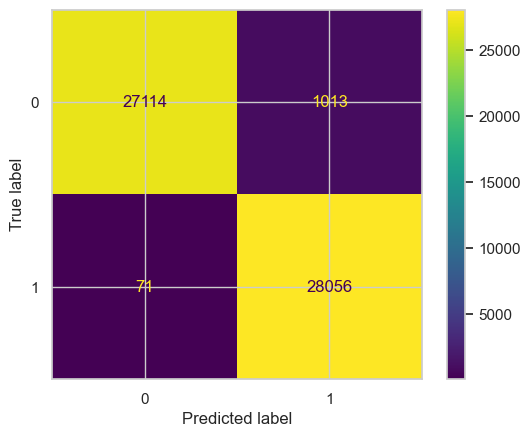

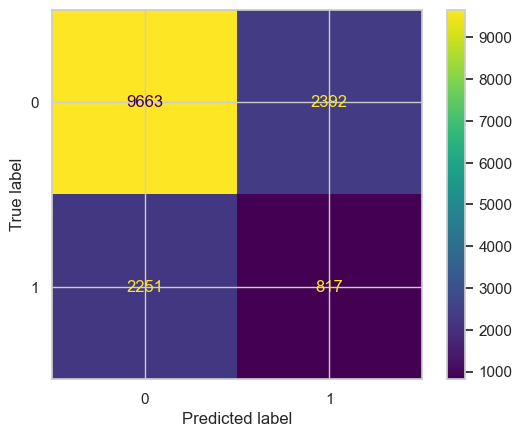

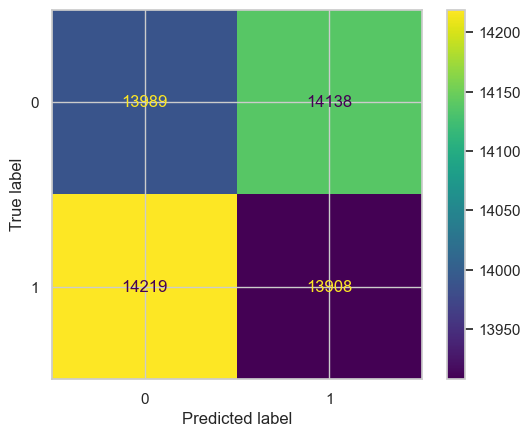

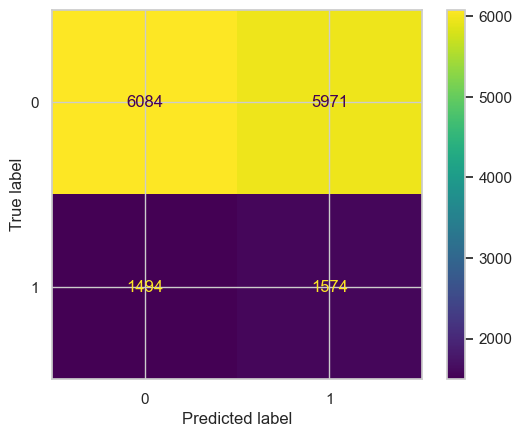

In [38]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, recall_score, precision_score
from sklearn.dummy import DummyClassifier

# Assuming you have your data and classifier set up as before

# Create a random classifier that makes random guesses
random_classifier = DummyClassifier(strategy="uniform", random_state=42)  # "uniform" strategy for random guessing

# Fit the random classifier on the training data
random_classifier.fit(X_train, y_train)

# Predictions and probabilities from your original classifier
y_train_pred = clf.predict(X_train)
y_train_proba = clf.predict_proba(X_train)
y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)

# Predictions from the random classifier
y_random_train_pred = random_classifier.predict(X_train)
y_random_test_pred = random_classifier.predict(X_test)

# Calculate and compare performance metrics
print("Train Acc (Original):", accuracy_score(y_train, y_train_pred))
print("Train F1 (Original):", f1_score(y_train, y_train_pred))
print("Train ROC AUC (Original):", roc_auc_score(y_train, y_train_proba[:, 1]))

print("Train Acc (Random Guessing):", accuracy_score(y_train, y_random_train_pred))
print("Train F1 (Random Guessing):", f1_score(y_train, y_random_train_pred))
print("Train ROC AUC (Random Guessing):", roc_auc_score(y_train, random_classifier.predict_proba(X_train)[:, 1]))

# Similar comparisons for test data
print("Test Acc (Original):", accuracy_score(y_test, y_test_pred))
print("Test F1 (Original):", f1_score(y_test, y_test_pred))
print("Test ROC AUC (Original):", roc_auc_score(y_test, y_test_proba[:, 1]))

print("Test Acc (Random Guessing):", accuracy_score(y_test, y_random_test_pred))
print("Test F1 (Random Guessing):", f1_score(y_test, y_random_test_pred))
print("Test ROC AUC (Random Guessing):", roc_auc_score(y_test, random_classifier.predict_proba(X_test)[:, 1]))

# Confusion matrices for both classifiers (original and random)
print("Confusion Matrix (Original) - Train:")
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)
print("Confusion Matrix (Original) - Test:")
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

print("Confusion Matrix (Random Guessing) - Train:")
ConfusionMatrixDisplay.from_estimator(random_classifier, X_train, y_train)
print("Confusion Matrix (Random Guessing) - Test:")
ConfusionMatrixDisplay.from_estimator(random_classifier, X_test, y_test)


Test Acc (Current): 0.2028698009654169
Test F1 (Current): 0.3373096586223957
Test recall_score (Current): 1.0
Test precision_score (Current): 0.2028698009654169


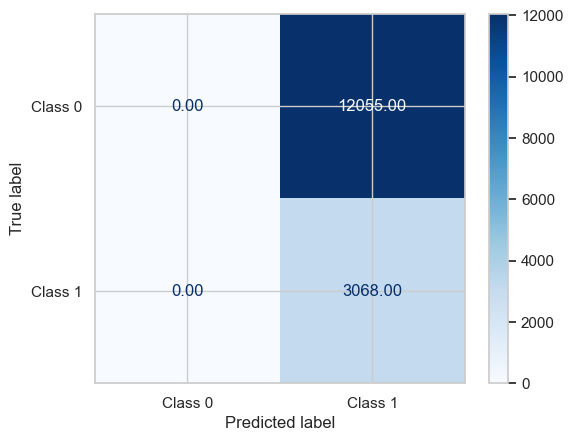

In [43]:
from sklearn.metrics import confusion_matrix
actual = y_test
predicted = y_test.copy()
predicted.loc[:] = 1
cm = confusion_matrix(actual, predicted)
# Create a ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

print("Test Acc (Current):", accuracy_score(actual, predicted))
print("Test F1 (Current):", f1_score(actual, predicted))
print("Test recall_score (Current):", recall_score(actual, predicted))
print("Test precision_score (Current):", precision_score(actual, predicted))

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, values_format='.2f')